In [1]:
#Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
%matplotlib inline

In [2]:
#Setting up the initial values and generating the function to draw the functions
n = 100
X = np.random.uniform(low = 0,high = 1,size = (n,2))
D = [1 if x2 < ((1/5)*np.sin(10*x1) + 0.3) or ((((x2 - 0.8)**2) + ((x1 - 0.5)**2)) < 0.15**2) else -1 for x1,x2 in X]
C_1 = [x for x,d in zip(X,D) if d == 1]
C_neg1 = [x for x,d in zip(X,D) if d == -1]
D = np.array(D).reshape(100,1).astype('float')
x = np.linspace(0,1,500)
y = np.linspace(0,1,500)
x1, y1 = np.meshgrid(x,y)
C = (y1 - 0.8)**2 + (x1 - 0.5)**2 - 0.15**2
S = (1/5)*np.sin(10*x1) - y1 + 0.3

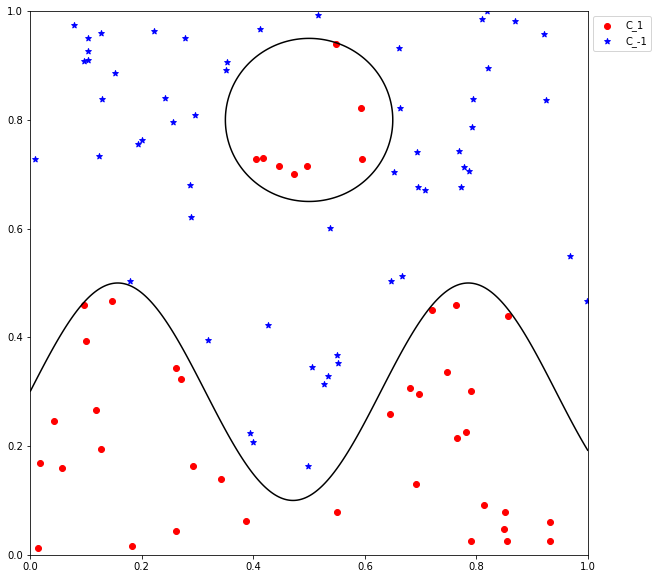

In [3]:
#Plot of inital points and the desired classes
fig,ax = plt.subplots(figsize=(10,10))
c1_plt = plt.scatter([c_1[0] for c_1 in C_1],[c_1[1] for c_1 in C_1],marker='o',label = 'C_1',color='red')
c_neg1_plt = plt.scatter([c_1[0] for c_1 in C_neg1],[c_1[1] for c_1 in C_neg1],marker='*',label = 'C_-1',color='blue')
circle_plot = plt.contour(x1,y1,C,[0],colors='black')
sine_plot = plt.contour(x1,y1,S,[0],colors='black')
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
_ = plt.xlim(xmin=0,xmax=1)
_ = plt.ylim(ymin=0,ymax=1)

In [4]:
#Defining kernel function for later use
def polynomial(x,y,d):
    return (np.dot(x,y) + 1) ** d

def gaussian(x,y,sigma):
    return np.exp(-0.5 * ((np.linalg.norm(x-y)**2)/(sigma**2)))

def linear(x,y):
    return np.dot(x,y)

In [5]:
#Function to get the K matrix, the kernal. trick for different kernels
def K_function(X,kernel,**kwargs):
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if kernel == 'linear':
                K[i,j] = linear(X[i],X[j])
            elif kernel == 'polynomial':
                K[i,j] = polynomial(X[i],X[j],kwargs['degree'])
            elif kernel == 'gaussian':
                K[i,j] = gaussian(X[i],X[j],kwargs['sigma'])
    return K

In [6]:
#Using CVXOPT for solving SVM optimization - library used only in this function
def optimization_solver(d,n,K):
    P = cvxopt.matrix(np.outer(d,d) * K)
    q = cvxopt.matrix(np.ones(n) * -1)
    A = cvxopt.matrix(d, (1,n))
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.diag(np.ones(n) * -1))
    h = cvxopt.matrix(np.zeros(n))
    output = cvxopt.solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(output['x'])
    support_vectors = alpha > 1e-5
    sv_indices = np.arange(len(alpha))[support_vectors]
    return alpha,sv_indices

In [7]:
#Funtion to get the value of bias
def get_thetha(n,alpha,D,sv_indices,K):
    sv = sv_indices[0]
    prod = 0
    for i in range(n):
        prod+= alpha[i] * D[i] * K[i,sv]
    thetha = D[sv] - prod
    return thetha

In [8]:
#Function to generate the discriminate value to classify the example using SVM
def discriminant_function(sv_indices,alpha,X,input_x,thetha,kernel,**kwargs):
    g_x = 0
    for i in range(n):
        if kernel == 'linear':
            g_x+= alpha[i] * D[i] * linear(X[i],input_x)
        elif kernel == 'polynomial':
            g_x+= alpha[i] * D[i] * polynomial(X[i],input_x,kwargs['degree'])
        elif kernel == 'gaussian':
            g_x+= alpha[i] * D[i] * gaussian(X[i],input_x,kwargs['sigma'])
    g_x+= thetha
    return g_x

In [9]:
#Function to classifify inputs based onn the kernel used
def classify_inputs(sv_indices,alpha,X,thetha,kernel,**kwargs):
    h = []
    h_pos = []
    h_neg = []
    for i in range(n):
        if kernel == 'linear':
            g_x = discriminant_function(sv_indices,alpha,X,X[i],thetha,kernel)
        elif kernel == 'polynomial':
            g_x = discriminant_function(sv_indices,alpha,X,X[i],thetha,kernel,degree = kwargs['degree'])
        elif kernel == 'gaussian':
            g_x = discriminant_function(sv_indices,alpha,X,X[i],thetha,kernel,sigma = kwargs['sigma'])
        if g_x < 0:
            h_neg.append(X[i])
        elif g_x > 0:
            h_pos.append(X[i])
        else:
            h.append(X[i])
    return h,h_pos,h_neg

In [10]:
#Combining all the above functions above to generate a single function to classify points using SVM.
def kernel_svm(n,D,X,x1,y1,kernel,**kwargs):
    if kernel == 'linear':
        K = K_function(X,kernel)
    elif kernel == 'polynomial':
        K = K_function(X,kernel,degree = kwargs['degree'])
    elif kernel == 'gaussian':
        K = K_function(X,kernel,sigma = kwargs['sigma'])
    alpha,sv_indices = optimization_solver(D,n,K)
    thetha = get_thetha(n,alpha,D,sv_indices,K)
    if kernel == 'linear':
        h,h_pos,h_neg = classify_inputs(n,alpha,X,thetha,kernel)
        input_X = np.array([x1.ravel(), y1.ravel()])
        g_x_line = discriminant_function(n,alpha,X,input_X,thetha,kernel)
    elif kernel == 'polynomial':
        h,h_pos,h_neg = classify_inputs(n,alpha,X,thetha,kernel,degree = kwargs['degree'])
        input_X = np.array([x1.ravel(), y1.ravel()])
        g_x_line = discriminant_function(n,alpha,X,input_X,thetha,kernel,degree = kwargs['degree'])
    elif kernel == 'gaussian':
        h,h_pos,h_neg = classify_inputs(n,alpha,X,thetha,kernel,sigma = kwargs['sigma'])
        input_X = np.array([x1.ravel(), y1.ravel()])
        g_x_line = discriminant_function(n,alpha,X,input_X,thetha,kernel,sigma = kwargs['sigma'])
    h_marginal_line = [[a,b] for g,a,b in zip(g_x_line,x1.ravel(),y1.ravel()) if -0.1 <= g <= 0.1]
    h_positive_line = [[a,b] for g,a,b in zip(g_x_line,x1.ravel(),y1.ravel()) if 0.9 <= g <= 1.1]
    h_negative_line = [[a,b] for g,a,b in zip(g_x_line,x1.ravel(),y1.ravel()) if -1.1 <= g <= -0.9]
    svs = [X[i] for i in sv_indices ]
    return h_marginal_line,h_positive_line,h_negative_line,h_pos,h_neg,svs

In [11]:
#Function to plot the final classification, hyperplanes and support vectors
def plot(h_marginal_line,h_positive_line,h_negative_line,h_pos,h_neg,svs,kernel,parameter):
    fig,ax = plt.subplots(figsize=(10,10))
    h_pos_plt = plt.scatter([h_p[0] for h_p in h_pos],[h_p[1] for h_p in h_pos],marker='o',label = 'Classified: C_1',color='red')
    h_neg_plt = plt.scatter([h_n[0] for h_n in h_neg],[h_n[1] for h_n in h_neg],marker='*',label = 'Classified: C_-1')
    _ = plt.scatter([h_m_l[0] for h_m_l in h_marginal_line],[h_m_l[1] for h_m_l in h_marginal_line],marker='.',label = 'Marginal Hyperplane',s=2,color='black')
    _ = plt.scatter([h_p_l[0] for h_p_l in h_positive_line],[h_p_l[1] for h_p_l in h_positive_line],marker='.',label = 'Positive Hyperplace',s=2,color='red')
    _ = plt.scatter([h_n_l[0] for h_n_l in h_negative_line],[h_n_l[1] for h_n_l in h_negative_line],marker='.',label = 'Negative Hyperplace',s=2,color='blue')
    _ = plt.scatter([c_1[0] for c_1 in svs],[c_1[1] for c_1 in svs],marker='*',label = 'Support Vectors',s=100,color='black')
    ax.legend(bbox_to_anchor=(1,1), loc="upper left")
    _ = plt.xlim(xmin=0,xmax=1)
    _ = plt.ylim(ymin=0,ymax=1)
    plt.title('{} kernel with degree/sigma: {} respectively'.format(kernel,parameter))
    plt.show()
    return

     pcost       dcost       gap    pres   dres
 0: -5.7845e+01 -1.6863e+02  3e+02  1e+01  3e+00
 1: -2.2977e+02 -3.6995e+02  2e+02  6e+00  2e+00
 2: -6.4009e+02 -8.0853e+02  2e+02  4e+00  1e+00
 3: -1.9193e+03 -2.2089e+03  3e+02  4e+00  1e+00
 4: -5.8192e+03 -6.4492e+03  6e+02  4e+00  1e+00
 5: -2.2670e+04 -2.4349e+04  2e+03  4e+00  1e+00
 6: -5.3385e+04 -5.7187e+04  4e+03  4e+00  1e+00
 7: -1.1879e+05 -1.2920e+05  1e+04  4e+00  1e+00
 8: -2.5484e+05 -2.8963e+05  3e+04  4e+00  1e+00
 9: -5.2449e+05 -6.3927e+05  1e+05  3e+00  8e-01
10: -8.2965e+05 -1.0169e+06  2e+05  1e+00  4e-01
11: -8.9145e+05 -9.2492e+05  3e+04  2e-01  4e-02
12: -8.9265e+05 -8.9304e+05  4e+02  2e-03  5e-04
13: -8.9265e+05 -8.9266e+05  4e+00  2e-05  5e-06
14: -8.9265e+05 -8.9265e+05  4e-02  2e-07  5e-08
15: -8.9265e+05 -8.9265e+05  4e-04  2e-09  7e-10
Optimal solution found.


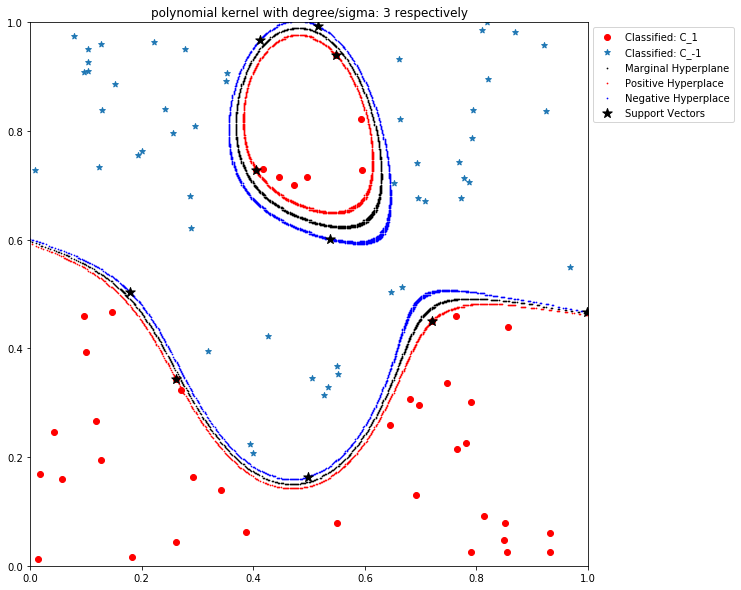

In [12]:
# Polynomial Kernel of degree 3
h_marginal_line,h_positive_line,h_negative_line,h_pos,h_neg,svs = kernel_svm(n,D,X,x1,y1,'polynomial',degree=3)
plot(h_marginal_line,h_positive_line,h_negative_line,h_pos,h_neg,svs,'polynomial',3)

With a polynomial Kernel of degree 4, we can see that SVM has classified all the points correctly, but hyperplanes are not well tuned. Continuing to check a higher degree

     pcost       dcost       gap    pres   dres
 0: -5.5423e+01 -1.5237e+02  3e+02  1e+01  3e+00
 1: -2.0928e+02 -3.4171e+02  2e+02  6e+00  1e+00
 2: -5.8256e+02 -7.3150e+02  2e+02  5e+00  1e+00
 3: -1.5530e+03 -1.7902e+03  3e+02  5e+00  1e+00
 4: -2.8194e+03 -3.1769e+03  4e+02  5e+00  1e+00
 5: -6.7674e+03 -7.5483e+03  8e+02  5e+00  1e+00
 6: -1.7838e+04 -2.0384e+04  3e+03  4e+00  1e+00
 7: -3.6013e+04 -4.3388e+04  8e+03  4e+00  9e-01
 8: -5.9970e+04 -7.4103e+04  1e+04  2e+00  5e-01
 9: -6.9977e+04 -7.5354e+04  5e+03  4e-01  1e-01
10: -7.0287e+04 -7.0457e+04  2e+02  1e-02  3e-03
11: -7.0309e+04 -7.0311e+04  3e+00  2e-04  4e-05
12: -7.0309e+04 -7.0310e+04  5e-02  2e-06  4e-07
13: -7.0310e+04 -7.0310e+04  5e-04  2e-08  4e-09
Optimal solution found.


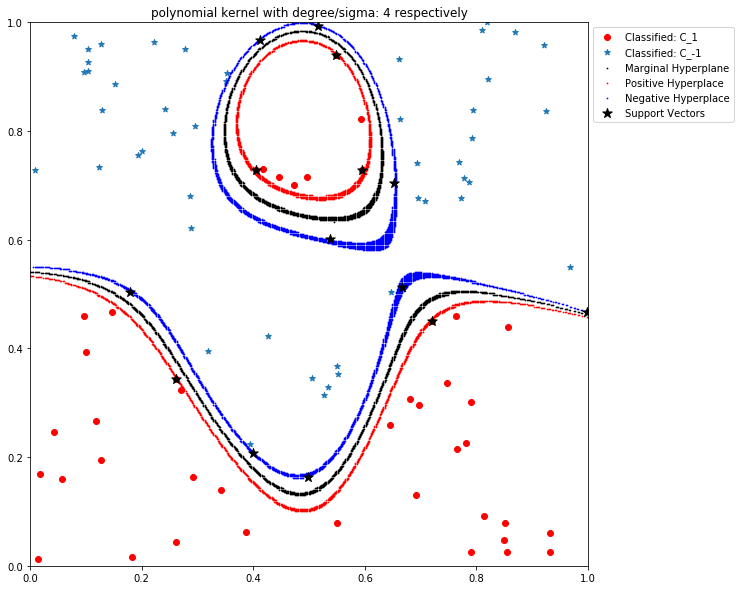

In [13]:
h_marginal_line,h_positive_line,h_negative_line,h_pos,h_neg,svs = kernel_svm(n,D,X,x1,y1,'polynomial',degree=4)
plot(h_marginal_line,h_positive_line,h_negative_line,h_pos,h_neg,svs,'polynomial',4)

     pcost       dcost       gap    pres   dres
 0: -5.3431e+01 -1.3733e+02  3e+02  1e+01  3e+00
 1: -1.9249e+02 -2.9175e+02  2e+02  7e+00  1e+00
 2: -4.7385e+02 -6.0175e+02  2e+02  6e+00  1e+00
 3: -1.4353e+03 -1.6569e+03  3e+02  5e+00  1e+00
 4: -3.1051e+03 -3.5720e+03  6e+02  5e+00  1e+00
 5: -6.8546e+03 -8.2125e+03  2e+03  5e+00  9e-01
 6: -1.0828e+04 -1.3259e+04  3e+03  3e+00  6e-01
 7: -1.2811e+04 -1.3979e+04  1e+03  6e-01  1e-01
 8: -1.2970e+04 -1.3015e+04  5e+01  2e-02  4e-03
 9: -1.2977e+04 -1.2978e+04  5e-01  2e-04  4e-05
10: -1.2977e+04 -1.2977e+04  5e-03  2e-06  4e-07
11: -1.2977e+04 -1.2977e+04  5e-05  2e-08  4e-09
Optimal solution found.


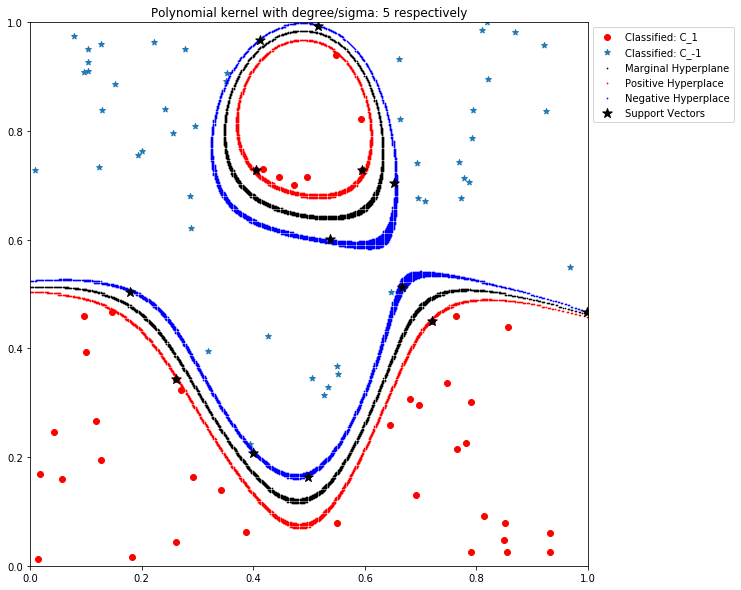

In [14]:
h_marginal_line,h_positive_line,h_negative_line,h_pos,h_neg,svs = kernel_svm(n,D,X,x1,y1,'polynomial',degree=5)
plot(h_marginal_line,h_positive_line,h_negative_line,h_pos,h_neg,svs,'Polynomial',5)

With a polynomial Kernel of degree 4 and degree 5, the data has fit well and SVM classifies all points correctly. The hyperplanes are also detailed well.